# Neural Networks

#### Linear Perceptron (or Artificial Neuron)
- In practice, a linear combination of weighted inputs
    
    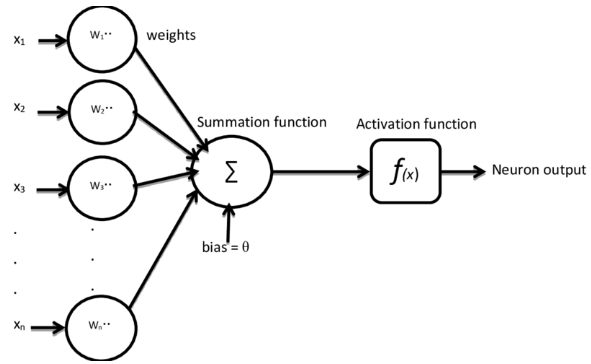
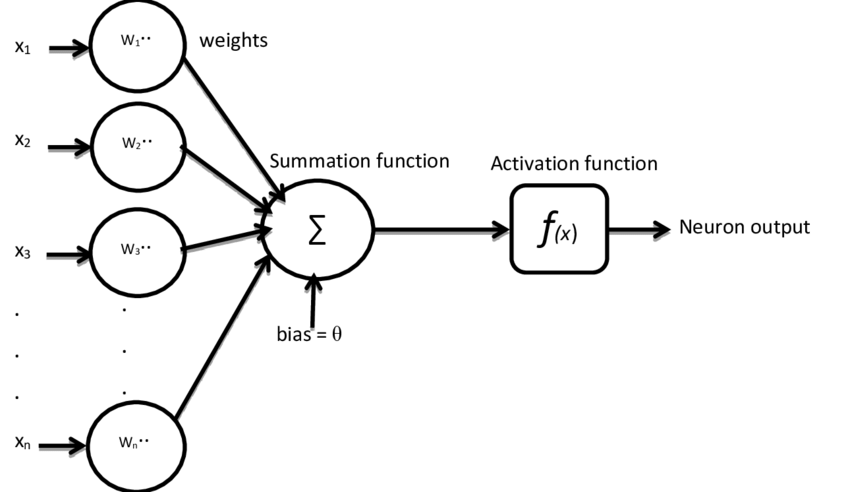
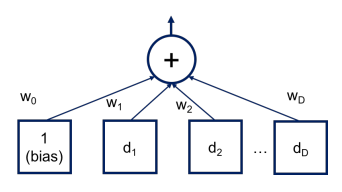

## Feed-forward Neural Network or Multilayer Perceptrons (MLPs)
- A Neural Network is an arrangment of many perceptron–like elements in a hierarchical structure.
- A layer of the neural network is a series of neurons that act in parallel. 
- The number of hidden layers + the output layer form the NN total number of layers.
    - The input feeds the *input layer*: one node for each dimension of the input
    - The input layer feeds the *hidden layers*: the number of nodes is a hyperparameter
    - The hidden layers feed  an *output layer*: one node if there are two classes (0/1); one node per class otherwise

    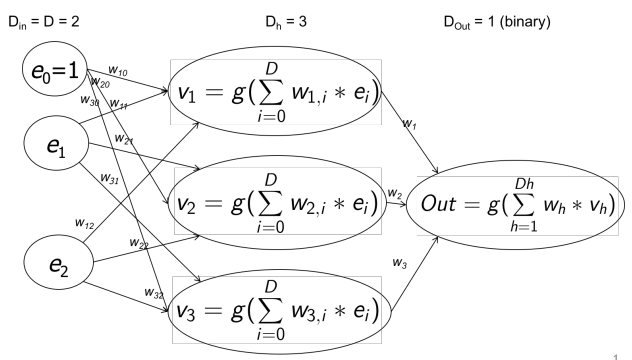

- Each hidden/output-layer neuron:
    1. receives as input a data (a signal, a real number)
    2. processes it, by multiplying by a weight plus a bias vector (which are specific to each neuron): $z=w^Tx+b$
    3. sums all the processed input data
    4. applies an element-wise nonlinear *activation function* $g(z)$
- Feed-forward means each node of one layer is connected to all the nodes of the following layer: in this way the signal flows from the input to the output, without loops

### Activation Function
- It's like passing data through a threshold
    - ***ReLU*** (Rectified Linear Unit)
        - $g(z)= max\{0, z\}$ 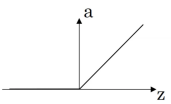
        - It's faster for training than others
        - The drawback is that the derivative is 0 when the value is negative
        - ReLU semplifies the space of activations because projects the data on the positive axes

        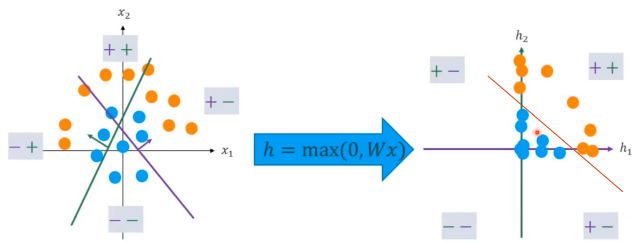
    - **sigmoid** ]0,1[ 
        - useful as activation function for the output layer of a binary classification problem
    - **arctangent** ]-1.5,1.5[ 
        - works better than the sigmoid as activation of the hidden layers, because it's antisymmetric: if the network connectivity is large, backpropagation learning with antisymmetric activation functions can yield faster convergence than non antisymmetric.
- The problem with sigmoid and arctangent is that when the value is too small or too large the derivative becomes really small and gradient descent slows down. Their use as activation functions for hidden units in feedforward networks is now discouraged.

- A linear activation function (therefore a linear neuron) is very affected by noise: $f(x_1+x_2) = f(x_1)+f(x_2)$. If $x_2$ is generated by noise, it is completely transferred to the output. In a non–linear system, in general, $f(x_1+x_2) \ne f(x_1)+f(x_2)$

### Deep Neural Network
- The difference between a Neural Network and a Deep Neural Network is that the former consists of a single layer of neurons, while the latter is composed of multiple layers of neurons. In other words, a DNN has at least three layers.
- Mathematically: 

    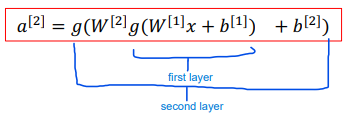

### Cost/Loss Function
- As in other supervised learning algorithms, the data is described by the function $y=f(x;\theta)$, where $\theta$ is a parameter. 
- The Neural Networks generate a function $\hat{y}$ where $\theta = \{W, b\}$
- The Neural Networks define a distribution $P(y_i| x_i;\theta)$, that's the probability of output $y_i$ given the sample $x_i$ with parameters $\theta$
- The *Likelihood function* is defined as $P(y|x;\theta)=\prod_{1}^{N}P(y_i| x_i;\theta)$, which is taken as *negative log-likelihood*: $$L(\hat{y},y)=-\sum_{1}^{N}log\space P(y_i| x_i;\theta)$$
that becomes the *Cross-Entropy* <sup>[(proof)](https://en.wikipedia.org/wiki/Maximum_likelihood_estimation#Relation_to_minimizing_Kullback%E2%80%93Leibler_divergence_and_cross_entropy)</sup> between the training data and the model's predictions (for Multi-class Classification): $$L(\hat{y},y)_{multi}=-\sum_{1}^{N}y_i * log(\hat{y_i})$$
- For Binary Classification:
$$L(\hat{y}, y)_{binary} = -(y * log(\hat{y}) + (1 - y) * log(1 - \hat{y}))$$

<br>

- The Loss Function is the mean of all the functions:

- We are trying to obtain the weights that minimise the Loss Function: $\hat{\theta} = \argmin_{\theta}J(\theta)$

#### Backpropagation
- The function we want to minimise or maximise is called the objective function or criterion. When we are minimising it, we
may also call it the cost function, loss function, or error function.
- To find the optimal weights, it's necessary to calculate the derivatives of the error function, going backwards through the NN, and updating the weights as decreasing the total error.
- The weights are changed subtracting the partial derivative multiplied by a *learning rate* constant. The learning rate influences the convercence speed and can be adjusted as a tradeoff between speed and precision.
- Error function:
$ E(w) = \frac{1}{2}(y-\text{Transfer}(w,x))^2$
    - $x$ is input, $y$ is output, $w$ is the weight verctor of a node
    - The error fuction moves towards a (local) minimum of the error, following its gradient 

- **Epoch**: a learning round over all the samples of the network. In general, after each epoch the network classification capability will be improved

#### Learning modes
- **Stochastic**: each forward propagation is immediately followed by a weight update. Introduces some noise in the gradient descent process, since the gradient is computed from a single data point. Reduces the chance of getting stucked in a local minimum
- **Batch**: many propagations occur before updating the weights, accumulating errors over the samples within a batch. Generally yelds faster and stable descent towards the local minimum, since the update is performed in the direction of the average error

#### Risks
- Local minima are possible, as usual in gradient tracking methods
- Overfitting is possible, if the network is too complex w.r.t. the complexity of the decision problem

In [15]:
import random
import os

import numpy as np

from sklearn import datasets
from sklearn.model_selection import train_test_split

import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader, Subset
from torch.utils.tensorboard import SummaryWriter  # log writer per visualizzare le loss

In [16]:
# For reproducibility, fix all the seeds


def fix_random(seed: int) -> None:
    """Fix all the possible sources of randomness.

    Args:
        seed: the seed to use.
    """
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)

    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True  # slower

In [17]:
# Define the Data Layer
# It must be extended to implement three methods


class MyDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.FloatTensor(X)  # the type is choosen by the type of the data
        self.y = torch.LongTensor(y)

        self.num_features = X.shape[1]
        self.num_classes = len(np.unique(y))

    def __len__(self):  # how many samples
        return self.X.shape[0]

    def __getitem__(
        self, idx
    ):  # return a single element of dataset (single sample or batch) (if the dataset is not in memory, it can read from file system and return the object)
        return self.X[idx, :], self.y[idx]

In [18]:
# define a simple neural network


class FeedForward(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(FeedForward, self).__init__()

        self.input_size = input_size
        self.hidden_size = hidden_size

        # Two layers
        self.fc2 = nn.Linear(self.hidden_size, num_classes)  # hidden to output
        self.fc1 = nn.Linear(self.input_size, self.hidden_size)  # input to hidden

        # activation function
        self.relu = nn.ReLU()

    # How layers are connected between them. This even defines the graph of backpropagation.
    def forward(self, x):
        h = self.fc1(x)  # first layer
        h = self.relu(h)  # activation function
        output = self.fc2(h)  # second layer
        return output

In [19]:
# Define a function for the training process
# model: instance of class to train
# criterion: loss function (cross-entropy, ...)
# optimizer
# epoch: number of
# train_loader and val_loader: who gives the batches
# device: cpu/gpu where i train
# writer and log_name: logging


def train_model(
    model,
    criterion,
    optimizer,
    epoch,
    train_loader,
    val_loader,
    device,
    writer,
    log_name="model",
):
    n_iter = 0
    best_valid_loss = float("inf")  # worst valid loss
    for epoch in range(epoch):
        model.train()  # activate train dropout level

        for (
            data,
            targets,
        ) in train_loader:  # get_item from MyDataset class (single item or batch)
            data, targets = data.to(device), targets.to(device)  # move data and targets to cpu/gpu

            optimizer.zero_grad()  # gradient to zero

            # Forward pass
            y_pred = model(data)

            # Compute Loss
            loss = criterion(y_pred, targets)
            writer.add_scalar("Loss/train", loss, n_iter)  # plot the batches

            # Backward pass
            loss.backward()
            optimizer.step()

            n_iter += 1

        labels, _, y_pred = test_model(model, val_loader, device)
        loss_val = criterion(y_pred, labels)
        writer.add_scalar("Loss/val", loss_val, epoch)  # plot the epochs

        # save best model
        if loss_val.item() < best_valid_loss:
            best_valid_loss = loss_val.item()
            if not os.path.exists("models"):
                os.makedirs("models")
            torch.save(model.state_dict(), "models/" + log_name)

    return model

In [20]:
# Define a function to evaluate the performance on validation and test sets


def test_model(model, data_loader, device):
    model.eval()  # activate evaluation dropout level
    y_pred = []
    y_test = []

    for data, targets in data_loader:
        data, targets = data.to(device), targets.to(device)
        y_pred.append(model(data))  # accumulate predictions
        y_test.append(targets)  # accumulate labels

    y_test = torch.stack(y_test).squeeze()
    y_pred = torch.stack(y_pred).squeeze()
    y_pred_c = y_pred.argmax(
        dim=1, keepdim=True
    ).squeeze()  # return max position of prediction array, that is the class I will associate with the sample

    return y_test, y_pred_c, y_pred

In [21]:
# look for GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device: {}".format(device))

Device: cpu


In [22]:
seed = 42

# Train hyperparameters
num_epochs = 100  # try 100, 200, 500
learning_rate = 0.01
batch = 32

In [23]:
data = datasets.load_iris()
X = data["data"]
y = data["target"]
indices = np.arange(X.shape[0])  # trick of Pytorch to split the data in train/val/test

# Separate indices
train_idx, test_idx = train_test_split(indices, test_size=0.2, stratify=y, random_state=seed)
train_idx, val_idx = train_test_split(train_idx, test_size=0.2, stratify=y[train_idx], random_state=seed)


# Scale data
train_mean = np.mean(X[train_idx, :], axis=0)
train_std = np.std(X[train_idx, :], axis=0)  # use only train
X = (X - train_mean) / train_std  # but apply to all dataset


# Create the dataset
my_dataset = MyDataset(X, y)


# Create subsets and relative dataloader
train_subset = Subset(my_dataset, train_idx)
train_loader = DataLoader(train_subset, batch_size=batch, shuffle=True)

val_subset = Subset(my_dataset, val_idx)
val_loader = DataLoader(val_subset, batch_size=1)

test_subset = Subset(my_dataset, test_idx)
test_loader = DataLoader(test_subset, batch_size=1)

Run Tensorboard from the command line:

"tensorboard --logdir runs/"

In [24]:
# fix the seed for reproducibility
fix_random(seed)


# Start tensorboard
writer = SummaryWriter()


# Define the architecture, loss and optimizer
hidden_size = 32  # architecture hyperparameter
model = FeedForward(my_dataset.num_features, hidden_size, my_dataset.num_classes)
model.to(device)  # move the NN to device
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)  # W and beta and learning rate


# Test before the training
y_test, y_pred_c, _ = test_model(model, test_loader, device)
acc = (y_test == y_pred_c).float().sum() / y_test.shape[0]
print("Accuracy before training:", acc.cpu().numpy())


# Train the model
model = train_model(model, criterion, optimizer, num_epochs, train_loader, val_loader, device, writer)


# Load best model
model.load_state_dict(torch.load("models/model"))
model.to(device)


# Test after the training
y_test, y_pred_c, _ = test_model(model, test_loader, device)
acc = (y_test == y_pred_c).float().sum() / y_test.shape[0]
print("Accuracy after training:", acc.cpu().numpy())


# Close tensorboard writer after a training
writer.flush()
writer.close()

Accuracy before training: 0.6666667


Accuracy after training: 0.8


In [25]:
# Let's define a new architecture


class FeedForwardPlus(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes, depth=1):
        super(FeedForwardPlus, self).__init__()

        model = [
            nn.Linear(input_size, hidden_size),
            nn.BatchNorm1d(hidden_size),
            nn.ReLU(),
        ]

        # Set of pytorch modules
        block = [
            nn.Linear(hidden_size, hidden_size),
            nn.BatchNorm1d(hidden_size),  # BatchNorm 1 dimention
            nn.ReLU(),
        ]

        for i in range(depth):
            model += block

        # Create sequential graph
        self.model = nn.Sequential(*model)

        # Output layer
        self.output = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        h = self.model(x)
        out = self.output(h)
        return out

In [26]:
# fix the seed for reproducibility
seed = 42
fix_random(seed)


# Start tensorboard
writer = SummaryWriter()


# Define the architecture, loss and optimizer
depth = 2  #  new hyperparameter
model = FeedForwardPlus(my_dataset.num_features, hidden_size, my_dataset.num_classes, depth)
print(model)
model.to(device)
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)


# Test before the training
y_test, y_pred_c, _ = test_model(model, test_loader, device)
acc = (y_test == y_pred_c).float().sum() / y_test.shape[0]
print("Accuracy before training:", acc.cpu().numpy())


# Train the model
model = train_model(model, criterion, optimizer, num_epochs, train_loader, val_loader, device, writer)


# Load best model
model.load_state_dict(torch.load("models/model"))
model.to(device)


# Test after the training
y_test, y_pred_c, _ = test_model(model, test_loader, device)
acc = (y_test == y_pred_c).float().sum() / y_test.shape[0]
print("Accuracy after training:", acc.cpu().numpy())
# from sklearn.metrics import classification_report
# print(classification_report(y_test.cpu(), y_pred_c.cpu()))


# Close tensorboard writer after a training
writer.flush()
writer.close()

FeedForwardPlus(
  (model): Sequential(
    (0): Linear(in_features=4, out_features=32, bias=True)
    (1): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=32, out_features=32, bias=True)
    (4): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): Linear(in_features=32, out_features=32, bias=True)
    (7): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU()
  )
  (output): Linear(in_features=32, out_features=3, bias=True)
)
Accuracy before training: 0.33333334
Accuracy after training: 0.93333334


In [27]:
# Grid Search
fix_random(seed)


# hyperparameters
hidden_sizes = [16, 32]
depths = [2, 4]
num_epochs = 1000
learning_rate = 0.01

import itertools

hyperparameters = itertools.product(hidden_sizes, depths)


# grid search loop
for hidden_size, depth in hyperparameters:
    fix_random(seed)

    log_name = "dim" + str(hidden_size) + "-dp" + str(depth) + "-ep" + str(num_epochs) + "-lr" + str(learning_rate)

    # start tensorboard
    writer = SummaryWriter("runs/" + log_name)

    # define architecture, loss and optimizer
    model = FeedForwardPlus(my_dataset.num_features, hidden_size, my_dataset.num_classes, depth)
    model.to(device)
    criterion = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

    # train
    model = train_model(
        model,
        criterion,
        optimizer,
        num_epochs,
        train_loader,
        val_loader,
        device,
        writer,
        log_name,
    )

    writer.flush()
writer.close()

In [28]:
# Choose and load the best model and evaluate it on the test set

# Re-instantiate the model and read best weights
model = FeedForwardPlus(my_dataset.num_features, 16, my_dataset.num_classes, 4)
model.load_state_dict(torch.load("models/dim16-dp4-ep1000-lr0.01"))
model.to(device)

y_test, y_pred_c, _ = test_model(model, test_loader, device)
acc = (y_test == y_pred_c).float().sum() / y_test.shape[0]

print("Accuracy of the best model on the test set:", acc.cpu().numpy())

Accuracy of the best model on the test set: 0.93333334
